In [ ]:
!pip install category_encoders

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, f1_score

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline 
from imblearn.pipeline import make_pipeline  #SMOTE 추가시 

#import shap
#from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

# hyperparaneter tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate

# encoder
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder

# SMOTE
from imblearn.over_sampling import SMOTE, ADASYN

## model 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, plot_importance


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import chisquare

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/MyDrive/hospital'

/content/drive/MyDrive/hospital


In [6]:
train = pd.read_csv('/content/drive/MyDrive/hospital/train.csv')
test = pd.read_csv('/content/drive/MyDrive/hospital/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/hospital/submission_sample.csv')
#submission.head()

In [7]:
print(train.shape, test.shape)  # 데이터의 갯수 적음  

(301, 58) (127, 58)


In [8]:
#train.info()
#test.info()

test[['employee1', 'employee2']].describe()  #type: object
test[['employee1', 'employee2']] = test[['employee1', 'employee2']].apply(lambda x: x.str.replace(',','').astype(float))
test[['employee1', 'employee2']].head(3)

,employee1,employee2
0,693.0,693.0
1,379.0,371.0
2,NaN,NaN


In [9]:
print(f"column 갯수: {len(train.columns)}\ncolumn 명: {train.columns}")

column 갯수: 58
column 명: Index(['inst_id', 'OC', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange'],
      dtype='object')


In [10]:
## target = 'OC' : 공백 제거, 칼럼명 변경
train['OC'] = train['OC'].map(lambda x: x.strip()) 
train['target'] = train['OC'].map({'open':1, 'close':0})
train = train.drop(columns = 'OC')

In [11]:
## categorical data
cat_des = train.describe(exclude = 'number')
cat_des

,sido,instkind,ownerChange
count,301,300,289
unique,16,7,2
top,gyeonggi,nursing_hospital,same
freq,49,144,247


In [12]:
for col in cat_des.columns:
    print(f"{col}: {train[col].unique()}, num: {train[col].nunique()} \n")

sido: ['choongnam' 'gyeongnam' 'gyeonggi' 'incheon' 'busan' 'jeonnam' 'seoul'
 'jeonbuk' 'choongbuk' 'ulsan' 'daejeon' 'daegu' 'gyeongbuk' 'gangwon'
 'gwangju' 'sejong'], num: 16 

instkind: ['nursing_hospital' 'general_hospital' 'hospital' 'traditional_clinic'
 'clinic' 'traditional_hospital' 'dental_clinic' nan], num: 7 

ownerChange: ['same' 'change' nan], num: 2 



In [13]:
## numerical data
nums = train.describe()
nums

,inst_id,sgg,openDate,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,...,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,target
count,301.000000,301.000000,3.010000e+02,296.000000,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,...,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,2.930000e+02,291.000000,288.000000,301.000000
mean,219.056478,81.039867,2.005013e+07,145.709459,1.288175e+10,2.014903e+09,1.033244e+10,5.654115e+09,2.696151e+08,5.115870e+08,...,8.146026e+09,3.860584e+09,1.510050e+09,4.471247e+09,2.709979e+09,5.273919e+09,9.786279e+08,142.546392,134.326389,0.950166
std,121.234869,50.969714,8.893815e+04,118.923890,2.043543e+10,7.460271e+09,1.493886e+10,8.083343e+09,8.023701e+08,1.060379e+09,...,1.255800e+10,6.797242e+09,2.953412e+09,7.659580e+09,4.564001e+09,1.081259e+10,4.688798e+09,160.191073,151.061786,0.217964
min,1.000000,1.000000,1.978012e+07,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.014780e+10,-2.781507e+09,0.000000,0.000000,0.000000
25%,112.000000,37.000000,2.001102e+07,52.750000,3.252112e+09,0.000000e+00,2.758201e+09,1.626053e+09,8.217133e+06,8.013395e+07,...,1.283220e+09,2.855741e+08,0.000000e+00,2.557878e+07,0.000000e+00,1.017573e+09,0.000000e+00,53.500000,53.750000,1.000000
50%,230.000000,75.000000,2.007113e+07,136.500000,5.524218e+09,2.104105e+08,4.684074e+09,2.659892e+09,4.363764e+07,1.831965e+08,...,3.784553e+09,1.454050e+09,8.542549e+07,1.969747e+09,1.100000e+09,2.894970e+09,0.000000e+00,80.000000,79.000000,1.000000
75%,321.000000,123.000000,2.011102e+07,193.000000,1.274839e+10,9.105278e+08,1.077876e+10,6.363400e+09,2.050331e+08,4.203330e+08,...,8.465053e+09,4.364714e+09,1.567967e+09,4.905441e+09,3.360000e+09,5.370285e+09,1.014447e+08,181.500000,170.000000,1.000000
max,428.000000,178.000000,2.017061e+07,656.000000,1.510000e+11,9.850332e+10,1.030000e+11,6.403559e+10,9.144171e+09,8.686380e+09,...,8.508858e+10,6.846878e+10,1.759375e+10,5.150388e+10,3.256147e+10,1.250000e+11,6.852730e+10,1200.000000,1200.000000,1.000000


In [14]:
## 결측치 
a = train.isnull().sum().to_frame()
b = test.isnull().sum().to_frame()
pd.concat([a,b], axis = 1)

,0,0
inst_id,0.0,0.0
sido,0.0,0.0
sgg,0.0,0.0
openDate,0.0,1.0
bedCount,5.0,8.0
instkind,1.0,2.0
revenue1,8.0,2.0
salescost1,8.0,2.0
sga1,8.0,2.0
salary1,8.0,2.0


In [15]:
## 중복
print(train.duplicated().sum(), test.duplicated().sum())

0 0


In [16]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max.columns', 90)

### 결측치 보완 
- 데이터의 값이 ```isnul() == True``` 또는 ```0.0``` 인 경우 모두를 결측치로 봐야 함
- instkind를 기준으로 결측치 채우기 
    

1. instkind 의 결측치 채우기

In [17]:
train.groupby(['instkind'])['bedCount', 'employee1', 'revenue1'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


bedCount                                                  \
                        count   mean    std   min    25%    50%    75%    max   
instkind                                                                        
clinic                  18.00   4.44   8.55  0.00   0.00   0.00   3.00  29.00   
dental_clinic            1.00   0.00    NaN  0.00   0.00   0.00   0.00   0.00   
general_hospital        37.00 261.57 105.57 55.00 196.00 243.00 306.00 545.00   
hospital                86.00  96.22  65.06 18.00  45.25  72.50 145.25 311.00   
nursing_hospital       144.00 172.34 120.45  0.00 110.00 153.50 194.50 656.00   
traditional_clinic       4.00   0.00   0.00  0.00   0.00   0.00   0.00   0.00   
traditional_hospital     6.00  46.67  16.97 28.00  33.25  44.00  60.00  69.00   

                     employee1                                            \
                         count   mean    std    min    25%    50%    75%   
instkind                                                                   
clinic                   17.00  84.76 140.25   4.00  16.00  21.00  73.00   
dental_clinic             1.00 107.00    NaN 107.00 107.00 107.00 107.00   
general_hospital         37.00 406.22 259.85  53.00 211.00 350.00 489.00   
hospital                 84.00 125.49 103.57   1.00  53.00  90.00 164.00   
nursing_hospital        141.00  97.82  74.08   0.00  54.00  73.00 100.00   
traditional_clinic        3.00  79.67  13.01  67.00  73.00  79.00  86.00   
traditional_hospital      7.00  45.00  30.76   9.00  25.00  42.00  63.50   

                             revenue1                                \
                         max    count           mean            std   
instkind                                                              
clinic                454.00    17.00 17314724242.71 40699343244.11   
dental_clinic         107.00     1.00 15472543033.00            NaN   
general_hospital     1200.00    33.00 41709177109.24 32413870581.52   
hospital              436.00    88.00 13375215026.26 16356020701.56   
nursing_hospital      406.00   141.00  6041756008.26  4678819664.28   
traditional_clinic     93.00     4.00  6754147564.50  5140679454.77   
traditional_hospital   87.00     8.00  3987219243.38  3273097461.94   

                                                                   \
                                min            25%            50%   
instkind                                                            
clinic                  43116940.00   912525500.00  1889868160.00   
dental_clinic        15472543033.00 15472543033.00 15472543033.00   
general_hospital         9000000.00 22552179836.00 37576799952.00   
hospital                       0.00  4163882720.50  7643508537.50   
nursing_hospital               0.00  3264274401.00  4629581758.00   
traditional_clinic     684550260.00  4642496205.75  6562300939.00   
traditional_hospital  1340971077.00  1685287935.00  2584781170.00   

                                                     
                                75%             max  
instkind                                             
clinic                6631600532.00 151000000000.00  
dental_clinic        15472543033.00  15472543033.00  
general_hospital     52626386641.00 141000000000.00  
hospital             15246700264.00 104000000000.00  
nursing_hospital      6859738630.00  25434636567.00  
traditional_clinic    8673952297.75  13207438120.00  
traditional_hospital  5317000135.75   9229935905.00

In [18]:
display(train[train.instkind.isnull() == True])
display(test[test.instkind.isnull() == True])

,inst_id,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,target
193,281,gyeonggi,12,20121213,NaN,NaN,305438818.00,22416139.00,467475340.00,254868810.00,13451554.00,90129732.00,4239523.00,0.00,-261130839.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,534296550.00,64355691.00,869364734.00,675718430.00,1333.00,24317070.00,5929772.00,0.00,-423739612.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,15.00,15.00,change,0


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange
120,413,NaN,gyeonggi,168,NaN,49.00,NaN,558362470.00,74434148.00,548290004.00,282685213.00,3138900.00,1281313631.00,33462261.00,0.00,-1342536413.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1160742200.00,130524845.00,761417108.00,459099355.00,1045466.00,120385797.00,70385797.00,0.00,149459916.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21.00,21.00,same
125,430,NaN,jeju,76,20010201.00,NaN,NaN,48927096685.00,41571482611.00,4721485293.00,1514547079.00,85098148.00,1270081418.00,837926647.00,31802061.00,1417343450.00,10282864993.00,9002630441.00,15569326.00,1280234552.00,29520302153.00,8782116864.00,7537348637.00,0.00,38590886632.00,9342813900.00,0.00,29248072732.00,25631200000.00,1212280514.00,0.00,47584771796.00,40158526993.00,5061218682.00,1404340907.00,99795507.00,1274425876.00,843338692.00,0.00,1190395752.00,7848232914.00,6707101749.00,15569326.00,1141131165.00,29150673121.00,7869000997.00,7112779552.00,0.00,37203968971.00,8485918077.00,0.00,28718050894.00,25631200000.00,-205062936.00,0.00,363.00,343.00,same


In [19]:
train.at[193,'instkind'] =  'clinic'  ## employee1 : 15  -- 병상수 30개 이하로 추정 > clinic
test.at[120,'instkind'] = 'nursing_hospital'  ## bedcount : 49 - employee1 : 21 (1인당 2병상), revenue1 평균 기준
test.at[125,'instkind'] = 'general_hospital'   ## employee1 평균값 기준

In [20]:
display(train[train.instkind.isnull() == True])
display(test[test.instkind.isnull() == True])

,inst_id,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,target


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange


2. instkind 기준 - bedCount 결측치 채우기

In [21]:
def zero_and_null(train):
    # 우선 bedcount === 0.0 인 값의 index 추출  
    zero = train[train['bedCount'] == 0.0].index.to_list()

    # np.nan으로 변경
    for i in zero:
        train.at[i, 'bedCount'] = np.nan 

    # np.nan 제외한 값들의 median으로 np.nan 채우기(값들의 편차가 크기 때문에 median 사용)
    values = train.groupby(['instkind'])['bedCount'].transform('median')
    train['bedCount'] = train['bedCount'].fillna(value = values)
    
    ## 여전히 np.nan인 경우(clinic), clinic <= 30 이므로 29로 채우기 
    train['bedCount'] = train['bedCount'].fillna(29)
    train.groupby(['instkind'])['bedCount'].describe()

    return train

In [22]:
train = zero_and_null(train)
test = zero_and_null(test)

3. instkind 기준 employee 의 결측치 채우기

In [23]:
def employee(train):
    # employee == 0인 값의 index 추출
    t1 = train[train['employee1'] == 0].index.to_list()
    t2 = train[train['employee2'] == 0].index.to_list()
    
    # np.nan으로 변경
    for i in t1:
        train.at[i, 'employee1'] = np.nan
    for j in t2:
        train.at[j, 'employee2'] = np.nan

    # np.nan 제외한 값들의 median으로 np.nan 채우기(값들의 편차가 크기 때문에 median 사용)
    values = train.groupby(['instkind'])['employee1'].transform('median')
    train['employee1'] = train['employee1'].fillna(value = values)

    values2 = train.groupby(['instkind'])['employee2'].transform('median')
    train['employee2'] = train['employee2'].fillna(value = values2)
    
    return train

In [24]:
train = employee(train)
test = employee(test)

In [25]:
train.groupby(['instkind'])['employee1','employee2'].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


employee1                                            \
                         count   mean    std    min    25%    50%    75%   
instkind                                                                   
clinic                   19.00  77.71 133.91   4.00  15.50  20.50  58.00   
dental_clinic             1.00 107.00    NaN 107.00 107.00 107.00 107.00   
general_hospital         37.00 406.22 259.85  53.00 211.00 350.00 489.00   
hospital                 88.00 123.88 101.44   1.00  58.25  90.00 162.50   
nursing_hospital        144.00  97.81  72.96  17.00  54.00  73.00 100.00   
traditional_clinic        4.00  79.50  10.63  67.00  76.00  79.00  82.50   
traditional_hospital      8.00  44.62  28.50   9.00  30.00  42.00  52.75   

                             employee2                                     \
                         max     count   mean    std    min    25%    50%   
instkind                                                                    
clinic                454.00     19.00  73.32 125.40   6.00  15.00  21.00   
dental_clinic         107.00      1.00 109.00    NaN 109.00 109.00 109.00   
general_hospital     1200.00     37.00 384.36 249.70  53.00 213.00 311.50   
hospital              436.00     88.00 114.81  89.01   1.00  54.50  89.50   
nursing_hospital      406.00    144.00  94.09  67.24   1.00  57.00  74.00   
traditional_clinic     93.00      4.00  75.50  13.08  67.00  69.25  70.00   
traditional_hospital   87.00      8.00  40.00  27.18  10.00  27.75  33.00   

                                     
                        75%     max  
instkind                             
clinic                56.50  425.00  
dental_clinic        109.00  109.00  
general_hospital     489.00 1200.00  
hospital             146.00  418.00  
nursing_hospital      95.00  454.00  
traditional_clinic    76.25   95.00  
traditional_hospital  44.75   88.00

4. opendate 결측치 채우기

In [26]:
## openDate : 타입변환, 결측치 보완(test:20200101)
def opendate_col(df):
    # 우선 str으로 변환 후 

    # test_data float 형식
    if df['openDate'].dtype == 'float':
        # test_data 중 nan - 임시로 20200101 => 'duration <0 '
        df['openDate'] = df['openDate'].fillna(20200101.0).astype(int).astype(str)
    else :
        df['openDate'] = df['openDate'].astype(str)

    # to_datetime
    df['opendate'] = pd.to_datetime(df['openDate'], format="%Y/%m/%d")

    df['open_year'] = df['opendate'].dt.year
    df['base'] = len(df)* 0 + 2017

    # 2017년 기준 개원기간
    df['duration'] = df['base'] - df['open_year']  

    return df

In [27]:
train = opendate_col(train)
test = opendate_col(test)

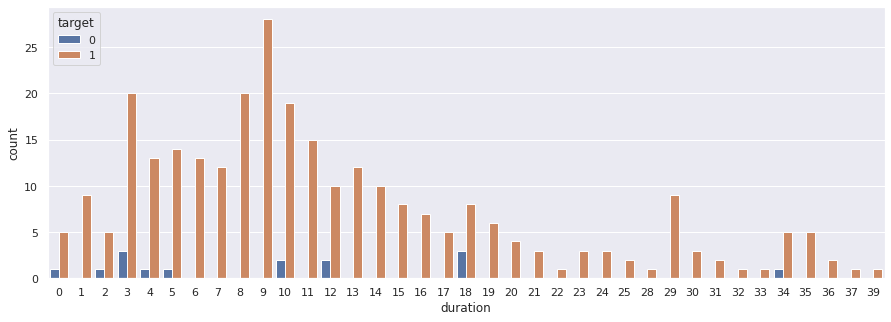

In [28]:
plt.figure(figsize = (15,5))
sns.set_theme()
sns.countplot(data = train, x = 'duration', hue='target')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


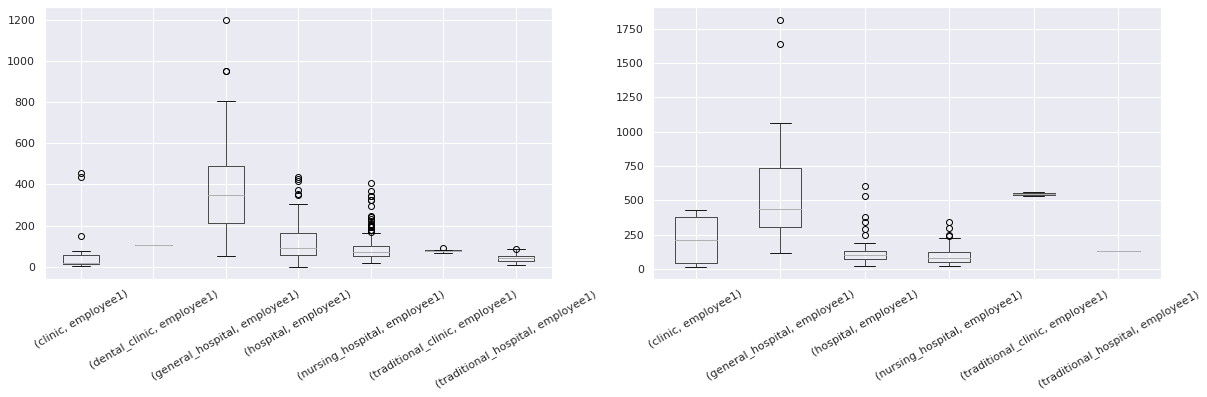

In [29]:
# instkind - employee
sns.set_theme()
fig, ax = plt.subplots(1,2, figsize = (20,5))

train.groupby(['instkind']).boxplot(column = 'employee1', rot = 30,
                                    sharex = True, sharey = True, subplots = False, figsize = (10,7), ax = ax[0])
test.groupby(['instkind']).boxplot(column = 'employee1', rot = 30,
                                    sharex = True, sharey = True, subplots = False, figsize = (10,7), ax = ax[1])
plt.show();

In [30]:
display(train.groupby(['instkind'])['employee1'].describe())
display(test.groupby(['instkind'])['employee1'].describe())

,count,mean,std,min,25%,50%,75%,max
instkind,,,,,,,,
clinic,19.00,77.71,133.91,4.00,15.50,20.50,58.00,454.00
dental_clinic,1.00,107.00,NaN,107.00,107.00,107.00,107.00,107.00
general_hospital,37.00,406.22,259.85,53.00,211.00,350.00,489.00,1200.00
hospital,88.00,123.88,101.44,1.00,58.25,90.00,162.50,436.00
nursing_hospital,144.00,97.81,72.96,17.00,54.00,73.00,100.00,406.00
traditional_clinic,4.00,79.50,10.63,67.00,76.00,79.00,82.50,93.00
traditional_hospital,8.00,44.62,28.50,9.00,30.00,42.00,52.75,87.00


,count,mean,std,min,25%,50%,75%,max
instkind,,,,,,,,
clinic,4.00,215.00,211.46,16.00,43.00,206.50,378.50,431.00
general_hospital,20.00,595.80,458.17,116.00,308.00,437.00,735.25,1816.00
hospital,36.00,142.97,132.40,22.00,73.00,102.00,133.25,604.00
nursing_hospital,64.00,97.38,70.28,17.00,47.00,76.00,121.25,340.00
traditional_clinic,2.00,546.00,19.80,532.00,539.00,546.00,553.00,560.00
traditional_hospital,1.00,132.00,NaN,132.00,132.00,132.00,132.00,132.00


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


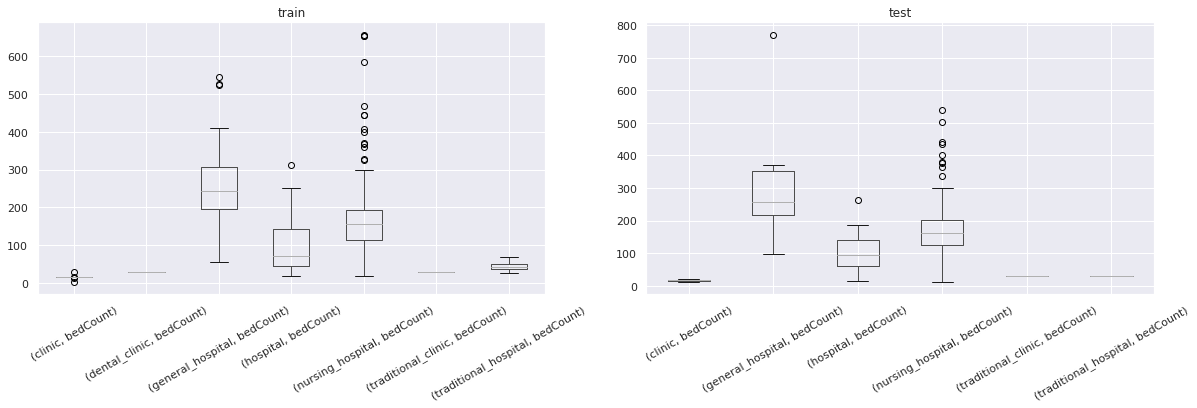

In [31]:
# instkind - bedcount 
sns.set_theme()
fig, ax = plt.subplots(1,2, figsize = (20,5))

train.groupby(['instkind']).boxplot(column = ['bedCount'], rot = 30,
                                    sharex = True, sharey = True, subplots = False, figsize = (10,7), ax = ax[0])
ax[0].set_title("train")
test.groupby(['instkind']).boxplot(column = ['bedCount'], rot = 30,
                                    sharex = True, sharey = True, subplots = False, figsize = (10,7), ax = ax[1])
ax[1].set_title("test")

plt.show();

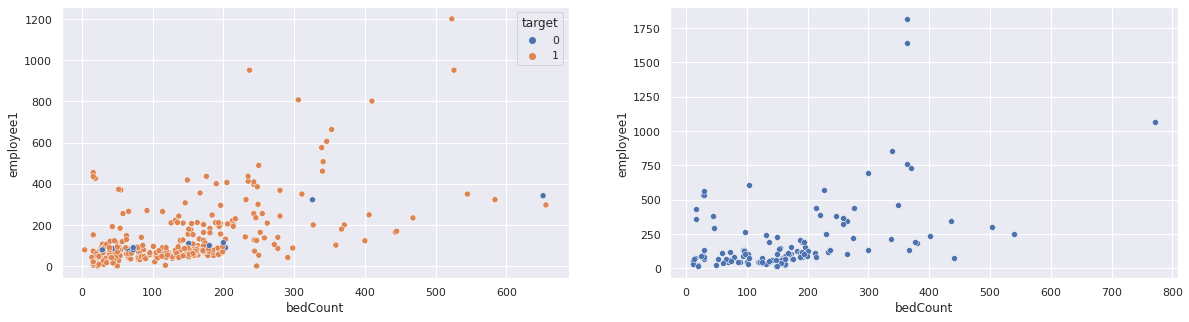

In [32]:
# bedcount - employee
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.scatterplot(data = train, x = 'bedCount', y = 'employee1', hue = 'target', ax = ax[0])
sns.scatterplot(data = test, x = 'bedCount', y = 'employee1', ax = ax[1])

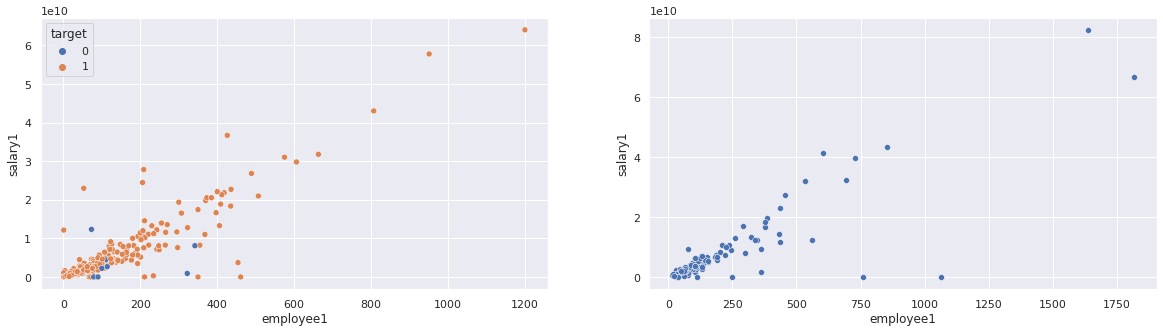

In [33]:
# employee - salary
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.scatterplot(data = train, x = 'employee1', y = 'salary1', hue = 'target', ax = ax[0])
sns.scatterplot(data = test, x = 'employee1', y = 'salary1', ax = ax[1])

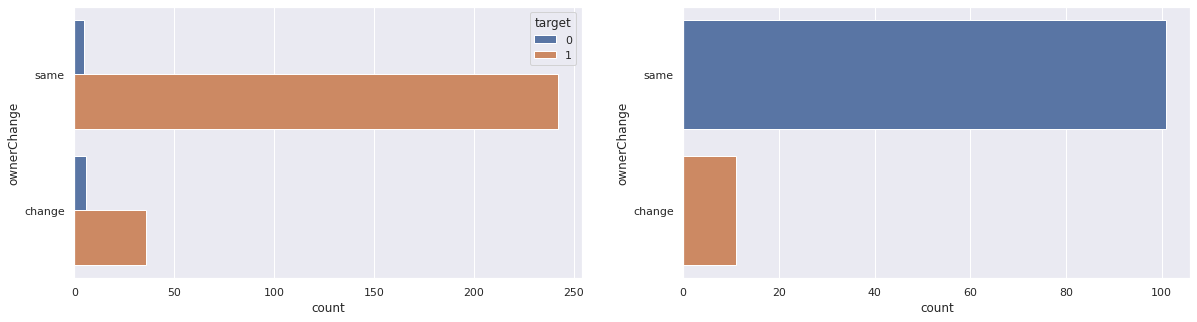

In [34]:
## ownerChange
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.countplot(data = train, y = 'ownerChange', hue = 'target', ax = ax[0])
sns.countplot(data = test, y = 'ownerChange', ax = ax[1])

In [35]:
# ownerChange - 결측치 보완(빈도수 높은 값 - same)
train['ownerChange'].fillna('same', inplace = True)
test['ownerChange'].fillna('same', inplace = True)

In [36]:
train.ownerChange.isnull().sum()

0

In [37]:
## numerical data 결측치 보완
num_cols = ['revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2']

# print(len(num_cols))
# for i in range(len(num_cols)):
#     print(train.groupby(['instkind'])[num_cols[i]].median())
#     print(test.groupby(['instkind'])[num_cols[i]].median())

In [38]:
display(train[train['instkind'] == 'dental_clinic'])
display(test[test['instkind'] == 'dental_clinic'])

,inst_id,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,target,opendate,open_year,base,duration
73,109,seoul,79,20120501,29.00,dental_clinic,15472543033.00,9405840570.00,5046172942.00,2268689456.00,42491802.00,403788486.00,398976016.00,425828.00,658807009.00,5788889613.00,5605380360.00,3977685248.00,183509253.00,13438186014.00,12751732448.00,464715970.00,0.00,12805430556.00,5953852404.00,2550000000.00,6851578152.00,6851578152.00,6421645071.00,0.00,13747537565.00,8660039908.00,4611549526.00,2099717546.00,8589077.00,467405759.00,415645399.00,0.00,17131449.00,3685664910.00,3516971530.00,2622831041.00,168693380.00,14931977213.00,14251469415.00,465705970.00,0.00,12854804061.00,5736049364.00,2361425349.00,7118754697.00,7118754697.00,5762838062.00,0.00,107.00,109.00,same,1,2012-05-01,2012,2017,5


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,opendate,open_year,base,duration


In [39]:
display(train[train['instkind'] == 'traditional_clinic'])
display(test[test['instkind'] == 'traditional_clinic'])

,inst_id,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,target,opendate,open_year,base,duration
30,52,gyeonggi,96,20010202,29.00,traditional_clinic,13207438120.00,2301603808.00,10269216425.00,5671130470.00,15051797.00,314375353.00,172718176.00,68212895.00,269081436.00,2042506734.00,1914822836.00,0.00,127683898.00,8963332085.00,8097412639.00,61340600.00,0.00,6926195411.00,6901195411.00,5631111110.00,25000000.00,0.00,4079643408.00,0.00,11835954883.00,1648423124.00,9907985262.00,5963381150.00,43262276.00,313362395.00,156262167.00,0.00,9446378.00,2122994887.00,1969267967.00,0.00,153726920.00,8822733591.00,8103954776.00,118843000.00,0.00,6491095906.00,6466095906.00,5764444442.00,25000000.00,0.00,4454632572.00,0.00,93.00,95.00,same,1,2001-02-02,2001,2017,16
130,192,choongnam,28,20011221,29.00,traditional_clinic,5961811521.00,5770950605.00,0.00,0.00,55672361.00,104120176.00,0.00,0.00,142413101.00,988933060.00,958341634.00,512711425.00,30591426.00,2286591951.00,1921541951.00,365050000.00,0.00,2354158255.00,1202171111.00,799675027.00,1151987144.00,999345696.00,921366756.00,0.00,6148148498.00,5860761306.00,0.00,0.00,39511949.00,81487714.00,0.00,0.00,245411427.00,1026390091.00,995930891.00,445325111.00,30459200.00,2175889460.00,1810839460.00,365050000.00,0.00,2398694011.00,1231391378.00,929675027.00,1167302633.00,995893096.00,803585540.00,0.00,67.00,67.00,same,1,2001-12-21,2001,2017,16
242,345,busan,69,20170420,29.00,traditional_clinic,684550260.00,0.00,561935625.00,301400000.00,8067090.00,2748281.00,1364824.00,18640111.00,109293333.00,1332665086.00,1331506704.00,62436350.00,0.00,772105779.00,502105779.00,270000000.00,0.00,95280871.00,94910871.00,0.00,370000.00,0.00,2009489994.00,0.00,774560815.00,0.00,756096906.00,363830000.00,15339220.00,4402666.00,617047.00,8050806.00,21349657.00,1172967732.00,1171014420.00,49160437.00,0.00,796808527.00,526808527.00,270000000.00,0.00,69579598.00,69209598.00,0.00,370000.00,0.00,1900196661.00,0.00,79.00,70.00,same,1,2017-04-20,2017,2017,0
261,366,gyeonggi,98,20170120,29.00,traditional_clinic,7162790357.00,875894383.00,5387361747.00,2654961482.00,76357947.00,312188211.00,289749590.00,0.00,663703963.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5061719833.00,649215654.00,4617804424.00,2086793510.00,137085864.00,1289228510.00,439264394.00,0.00,-1357442891.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,79.00,70.00,same,0,2017-01-20,2017,2017,0


,inst_id,OC,sido,sgg,openDate,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,opendate,open_year,base,duration
10,24,NaN,gyeonggi,169,20071109,29.00,traditional_clinic,70340410791.00,15703609481.00,51774179537.00,32040054580.00,446597276.00,1730254303.00,1658762094.00,238518390.00,1340446356.00,9285804386.00,8766996223.00,13083630.00,518808163.00,56412209806.00,55132585663.00,940029255.00,0.00,57040737104.00,18867341663.00,10966044435.00,38173395441.00,23647710000.00,8657277088.00,7321694997.00,56091019850.00,12750399682.00,41355281669.00,26619996530.00,1604990993.00,2068379179.00,1941941841.00,0.00,1521950313.00,9677090984.00,9071466702.00,11432010.00,605624282.00,62560959004.00,60246819338.00,980529255.00,0.00,62419285026.00,15143328141.00,7749622618.00,47275956885.00,33318400000.00,9818764962.00,8483182871.00,532.00,409.00,same,2007-11-09,2007,2017,10
122,424,NaN,jeonnam,33,20011012,29.00,traditional_clinic,22330305917.00,848465677.00,18492554091.00,12322408350.00,423628901.00,1304816893.00,417949094.00,415894516.00,1692203641.00,18292922272.00,18184287157.00,3728960464.00,108635115.00,13076229994.00,12656386688.00,312415620.00,0.00,15827363792.00,12859729048.00,0.00,2967634744.00,0.00,15541788474.00,0.00,22395094765.00,849208518.00,18055026392.00,11388845170.00,483447584.00,1574477731.00,571079590.00,553752070.00,1846077638.00,17088185795.00,17018788324.00,3084698893.00,69397471.00,12393573118.00,11730061607.00,310415620.00,0.00,15632174080.00,12881803375.00,0.00,2750370705.00,0.00,13849584833.00,0.00,560.00,409.00,same,2001-10-12,2001,2017,16


In [40]:
def numeric_null(train):

    ## 값이 0 또는 null 인 index 추출
    for i in range(len(num_cols)):
        indx = []
        indx.extend(train[train[num_cols[i]] == 0.0].index)
        indx.extend(train[train[num_cols[i]].isnull()== True].index)
        indx.sort()

        ## 모두 np.nan으로 변경       
        for j in indx:
            train.at[j, num_cols[i]] = np.nan
    

    for i in range(len(num_cols)):            
        ## np.nan -> instkind 기준에 따른 median으로 채우기
        values = train.groupby(['instkind'])[num_cols[i]].transform('median')
        train[num_cols[i]] = train[num_cols[i]].fillna(value = values)
        ## 데이터 없는 경우 0으로 채우기
        train[num_cols[i]] = train[num_cols[i]].fillna(value = 0.0)

    return train

In [41]:
train = numeric_null(train)
test = numeric_null(test)

* feature engineering 


In [42]:
def feature_engineering(dataframe):

    df = dataframe.copy()
    # 매출총이익(tot_profit)
    df['tot_profit1'] = df['revenue1'] - df['salescost1']  
    df['tot_profit2'] = df['revenue2'] - df['salescost2'] 

    # 매출총이익률(rat_profit) = 매출총이익/매출액
    df['rat_profit1'] = (df['tot_profit1']/df['revenue1']+1) * 100
    df['rat_profit2'] = (df['tot_profit2']/df['revenue2']+1) * 100

    # 영업이익
    df['ope_profit1'] = df['revenue1'] - df['salescost1'] - df['sga1'] - df['salary1']
    df['ope_profit2'] = df['revenue2'] - df['salescost2'] - df['sga2'] - df['salary2']

    # ROE = 당기순이익/순자산
    df['ROE1'] = df['profit1']/(df['netAsset1']+1) * 100
    df['ROE2'] = df['profit2']/(df['netAsset2']+1) * 100

    # 총자산(tot_asset) = 부채 + 자본
    df['tot_asset1'] = df['debt1'] + df['netAsset1']
    df['tot_asset2'] = df['debt2'] + df['netAsset2']

    # 부채비율(debt_ratio) = 부채/총자산
    df['debt_ratio1'] = df['debt1']/df['tot_asset1'] * 100
    df['debt_ratio2'] = df['debt2']/df['tot_asset2'] * 100

    # ROA = 당기순이익/총자산
    df['ROA1'] = df['profit1']/(df['tot_asset1']+1) * 100
    df['ROA2'] = df['profit2']/(df['tot_asset1']+1) * 100

    # 2016대비 2017 변화율
    df['delta_employee'] = (df['employee1']/(df['employee2']+0.1)) * 100
    df['delta_tot_profit'] = (df['tot_profit1']/(df['tot_profit2']+1)) * 100
    df['delta_rat_profit'] = (df['rat_profit1']/(df['rat_profit2']+1)) 
    df['delta_ope_profit'] = (df['ope_profit1']/(df['ope_profit2']+1)) * 100
    df['delta_ROE'] = (df['ROE1']/(df['ROE2']+1))
    df['delta_tot_asset'] = (df['tot_asset1']/(df['tot_asset2']+1)) * 100
    df_new = df.copy()
    
    return df_new

In [43]:
train = feature_engineering(train)
test = feature_engineering(test)

In [44]:
train.columns

Index(['inst_id', 'sido', 'sgg', 'openDate', 'bedCount', 'instkind',
       'revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2', 'ownerChange', 'target', 'opendate',
       'open_year', 'base', 'duration', 'tot_profit1', 'tot_profit2',
       'rat_profit1', 'rat_profit2', 'ope_profit1', 'ope_profit2', 'ROE1',
       '

* correlation/t test/chi-squre test

In [45]:
## feature engineering 전
num_cols = ['inst_id', 'sgg','bedCount','revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'employee1', 'employee2','duration',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2', 'target']

In [46]:
#num_train = train[num_cols]
#num_test = test[num_cols[:-1]]

In [47]:
## feature engineering 후
n_num_cols = ['inst_id',  'sgg','bedCount','revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',
       'employee1', 'employee2','duration','tot_profit1', 'tot_profit2',
       'rat_profit1', 'rat_profit2', 'ope_profit1', 'ope_profit2', 'ROE1',
       'ROE2', 'tot_asset1', 'tot_asset2', 'debt_ratio1', 'debt_ratio2',
       'ROA1', 'ROA2', 'delta_employee', 'delta_tot_profit',
       'delta_rat_profit', 'delta_ope_profit', 'delta_ROE', 'delta_tot_asset','target']

In [48]:
num_train = train[n_num_cols]
num_test = test[n_num_cols[:-1]]

In [49]:
## correlation
def check(x, props=''):
    return np.where((x>=0.8) & (x<1.0), props, '')

num_train.iloc[:,1:].corr().style.background_gradient(cmap='coolwarm')

,sgg,bedCount,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,duration,tot_profit1,tot_profit2,rat_profit1,rat_profit2,ope_profit1,ope_profit2,ROE1,ROE2,tot_asset1,tot_asset2,debt_ratio1,debt_ratio2,ROA1,ROA2,delta_employee,delta_tot_profit,delta_rat_profit,delta_ope_profit,delta_ROE,delta_tot_asset,target
sgg,1.000000,0.030529,0.060890,0.032044,0.053677,0.038208,0.069007,0.088291,0.053385,0.022745,0.044499,0.066789,0.066754,-0.029260,0.036336,0.058215,0.065651,0.056827,0.004739,0.094677,0.096872,0.070716,0.080098,0.056446,0.014228,-0.039933,0.063218,0.029254,0.056111,0.045399,0.023899,0.048007,0.034288,0.005540,0.048822,0.077120,0.076449,-0.035966,0.044272,0.045612,0.047751,0.050012,0.004739,0.073000,0.068244,0.019604,0.058697,0.042898,0.027248,-0.047610,0.054341,0.049002,-0.026470,0.066970,0.072235,-0.004096,-0.005566,-0.012945,-0.013295,-0.056847,-0.010175,0.064491,0.059319,0.093670,0.102264,-0.019135,-0.007068,0.019048,0.034069,0.019807,-0.036119,-0.060456,0.045327,-0.043927
bedCount,0.030529,1.000000,0.305612,0.124288,0.389693,0.456599,0.214695,0.219575,0.304308,0.080615,0.041635,0.215339,0.215424,0.189962,0.141302,0.375961,0.404169,0.164530,0.242431,0.380043,0.391351,0.358719,0.323567,0.252882,0.222881,-0.005576,0.315220,0.151758,0.403023,0.442317,0.231395,0.212160,0.308990,0.037179,-0.007460,0.223649,0.220629,0.224334,0.129516,0.373675,0.402751,0.158908,0.242431,0.363221,0.340476,0.314712,0.307285,0.292650,0.276394,0.052159,0.556009,0.531303,-0.015228,0.354175,0.357318,-0.026299,-0.022688,-0.475846,-0.475108,-0.099692,0.010283,0.354544,0.367759,0.031491,0.030340,0.031519,0.071241,0.149178,0.009673,-0.104961,0.093274,0.015641,0.102048,-0.009010
revenue1,0.060890,0.305612,1.000000,0.813672,0.942329,0.862613,0.484791,0.542834,0.439952,0.537611,0.186985,0.854020,0.847518,0.455837,0.797507,0.775058,0.731265,0.644554,-0.334607,0.794913,0.757140,0.511468,0.672915,0.357224,0.657055,0.352168,0.981491,0.829056,0.914561,0.848748,0.676418,0.664097,0.446501,0.574294,0.345020,0.836764,0.828248,0.388699,0.788632,0.754812,0.713766,0.623358,-0.334607,0.792873,0.672227,0.506496,0.703525,0.397111,0.679406,0.418153,0.815654,0.798880,0.274574,0.957896,0.939092,0.038523,0.037348,-0.762612,-0.719127,-0.178640,0.060656,0.851737,0.842002,0.043478,0.039618,0.043998,0.035804,-0.035167,0.004937,0.022731,0.036246,-0.020109,-0.006659,0.078264
salescost1,0.032044,0.124288,0.813672,1.000000,0.604047,0.521432,0.330530,0.357669,0.175784,0.314761,0.058612,0.701188,0.699230,0.261922,0.581546,0.469753,0.433054,0.560507,-0.264789,0.531946,0.542340,0.293221,0.421336,0.149982,0.446032,0.174431,0.804819,0.992625,0.600318,0.516881,0.482904,0.386023,0.183022,0.417119,0.203916,0.692816,0.689847,0.205970,0.588027,0.445786,0.415653,0.520444,-0.264789,0.496310,0.441599,0.267248,0.419823,0.156582,0.489576,0.213912,0.570138,0.558567,0.193950,0.612506,0.617853,-0.035314,-0.032729,-0.462640,-0.432648,-0.170559,0.023393,0.573631,0.560214,0.029779,0.019029,-0.002050,0.018412,-0.013760,-0.008936,-0.025733,-0.014631,-0.006366,-0.006879,0.040771
sga1,0.053677,0.389693,0.942329,0.604047,1.000000,0.939317,0.488596,0.534316,0.532331,0.531498,0.150266,0.793040,0.784245,0.489330,0.799302,0.818536,0.781772,0.610466,-0.344712,0.828829,0.787235,0.597422,0.707277,0.420691,0.649087,0.382889,0.930467,0.632623,0.974178,0.926432,0.676719,0.683430,0.548621,0.533204,0.312650,0.774526,0.762685,0.447472,0.782986,0.811712,0.776131,0.596411,-0.344712,0.850399,0.726911,0.605468,0.752034,0.480881,0.667565,0.462797,0.844459,0.834201,0.3046

In [50]:
## ttest
topen = num_train[num_train['target'] == 1]
tclose = num_train[num_train['target'] == 0]

In [51]:
cols = []
t_stat = []
p_val = []
for col in n_num_cols[1:-1]:
    t , p = stats.ttest_ind(topen[col], tclose[col], equal_var = False)
    cols.append(col)
    t_stat.append(t)
    p_val.append(p)
    #print(f"col: {col}, ttest: {stats.ttest_ind(topen[col], tclose[col], equal_var = False)}")

pd.set_option('display.float_format', '{:.6f}'.format)
a = pd.DataFrame(columns = ['column', 't_stats', 'p_value'], data = [[cols[i], t_stat[i], p_val[i]] for i in range(len(n_num_cols[1:-1]))])

re = []
for i in range(a.shape[0]):
    if a['p_value'].iloc[i] < 0.05:
        r = 'reject'
    else: 
        r = 'accept'
    re.append(r)

a['r'] = re

def check(v, props = ''):
    return np.where(v == 'reject', props, '')

a.style.apply(check, props = 'background-color: green')

,column,t_stats,p_value,r
0,sgg,-0.654528,0.522635,accept
1,bedCount,-0.112660,0.911822,accept
2,revenue1,3.663528,0.000801,reject
3,salescost1,2.005756,0.051561,accept
4,sga1,3.873435,0.000514,reject
5,salary1,3.276134,0.003058,reject
6,noi1,1.023372,0.317006,accept
7,noe1,1.844276,0.073785,accept
8,interest1,-0.128257,0.899362,accept
9,ctax1,1.249457,0.223966,accept


In [52]:
ind = np.where(a['r'] == 'reject')[0].tolist()
ttest_results = [a.iloc[i].column for i in ind]
print(ttest_results)

['revenue1', 'sga1', 'salary1', 'inventoryAsset1', 'OnonCAsset1', 'debt1', 'NCLiabilities1', 'inventoryAsset2', 'OnonCAsset2', 'tot_profit1', 'ope_profit1', 'debt_ratio1']


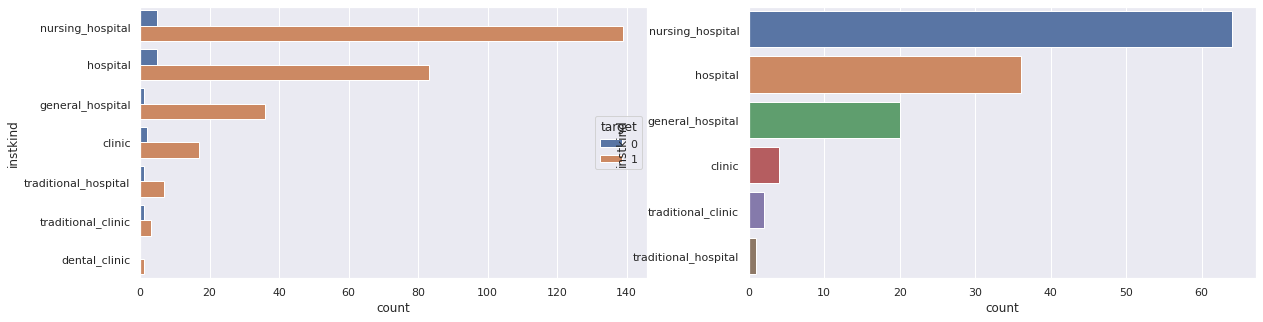

In [53]:
## instkind
fig, ax = plt.subplots(1,2, figsize = (20,5))
sns.countplot(data = train, y = 'instkind', hue = 'target', ax = ax[0], order = train.instkind.value_counts().index)
sns.countplot(data = test, y = 'instkind', ax = ax[1], order = test.instkind.value_counts().index)

In [54]:
## chi-squre test
from scipy.stats import chi2_contingency

display(pd.crosstab(train['target'], train['ownerChange'], margins = True))
ct = pd.crosstab(train['target'], train['ownerChange'], margins = True)
chi2, p, dof, expected = chi2_contingency(ct)
print(chi2, p)
print(" ")
display(pd.crosstab(train['target'], train['instkind'], margins = True))
ct = pd.crosstab(train['target'], train['instkind'], margins = True)
chi2, p, dof, expected = chi2_contingency(ct)
print(chi2, p)

ownerChange,change,same,All
target,,,
0,6,9,15
1,36,250,286
All,42,259,301


8.920204120204119 0.06312524070827037
 


instkind,clinic,dental_clinic,general_hospital,hospital,nursing_hospital,traditional_clinic,traditional_hospital,All
target,,,,,,,,
0,2,0,1,5,5,1,1,15
1,17,1,36,83,139,3,7,286
All,19,1,37,88,144,4,8,301


6.816131968494409 0.9415674376720462


In [55]:
train_df = train.drop(['opendate','openDate','open_year','base', 'target', 'sido'],axis = 1)
test.drop(['opendate','openDate','open_year','base', 'OC', 'sido'], axis = 1, inplace = True)

In [56]:
train_df.set_index('inst_id', inplace = True)
test.set_index('inst_id', inplace = True)

### train/val/test split

In [57]:
train.set_index('inst_id', inplace = True)

In [58]:
## train/val/test
X_train, X_val, y_train, y_val = train_test_split(train_df, train['target'], train_size = 0.7, test_size = 0.3, stratify = train['target'], random_state = 42)

## train/test
X = train_df
y = train['target']

X_test = test
print(X_train.shape,y_train.shape, X_test.shape)

(210, 75) (210,) (127, 75)


In [59]:
X_train.head()

,sgg,bedCount,instkind,revenue1,salescost1,sga1,salary1,noi1,noe1,interest1,ctax1,profit1,liquidAsset1,quickAsset1,receivableS1,inventoryAsset1,nonCAsset1,tanAsset1,OnonCAsset1,receivableL1,debt1,liquidLiabilities1,shortLoan1,NCLiabilities1,longLoan1,netAsset1,surplus1,revenue2,salescost2,sga2,salary2,noi2,noe2,interest2,ctax2,profit2,liquidAsset2,quickAsset2,receivableS2,inventoryAsset2,nonCAsset2,tanAsset2,OnonCAsset2,receivableL2,debt2,liquidLiabilities2,shortLoan2,NCLiabilities2,longLoan2,netAsset2,surplus2,employee1,employee2,ownerChange,duration,tot_profit1,tot_profit2,rat_profit1,rat_profit2,ope_profit1,ope_profit2,ROE1,ROE2,tot_asset1,tot_asset2,debt_ratio1,debt_ratio2,ROA1,ROA2,delta_employee,delta_tot_profit,delta_rat_profit,delta_ope_profit,delta_ROE,delta_tot_asset
inst_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
50,128,149.000000,hospital,58201450435.000000,8002571377.000000,48778584637.000000,21839686580.000000,418567384.000000,383067082.000000,296607165.000000,578397450.000000,877397273.000000,6707079632.000000,6015740971.000000,14538250.000000,691338661.000000,36060444883.000000,33911264854.000000,793000000.000000,0.000000,32936293856.000000,16022058091.000000,6066075906.000000,16914235765.000000,5940000000.000000,9831230659.000000,26928.000000,55675951519.000000,6228445364.000000,44832427518.000000,19701272360.000000,286410207.000000,2878319088.000000,471474568.000000,192228400.000000,1830941356.000000,7762225881.000000,7144963104.000000,19370000.000000,617262777.000000,37587470374.000000,35412478668.000000,905000000.000000,0.000000,37247076511.000000,17806574974.000000,8574163266.000000,19440501537.000000,8374475000.000000,8102619744.000000,26928.000000,418.000000,418.000000,same,16,50198879058.000000,49447506155.000000,186.250220,188.813042,-20419392159.000000,-15086193723.000000,8.924592,22.596906,42767524515.000000,45349696255.000000,77.012393,82.133023,2.051550,4.281149,99.976082,101.519536,0.981230,135.351518,0.378210,94.306088
411,167,16.000000,clinic,663950938.000000,3479105.000000,680570092.000000,443978109.000000,68479716.000000,47446193.000000,42074250.000000,8881100.000000,935264.000000,540289857.000000,503980739.000000,66512455.000000,8311914.000000,2402643969.000000,2402543969.000000,38139000.000000,0.000000,1579396583.000000,446175930.000000,1078728901.000000,718853232.000000,859426616.000000,1499369642.000000,76602878.000000,829777705.000000,2876907.000000,864945762.000000,507810157.000000,118965266.000000,47415526.000000,44221426.000000,6667818.000000,33504776.000000,584347035.000000,581367035.000000,34465364.500000,25326910.000000,2640662175.000000,2640662175.000000,201035000.000000,0.000000,1627828068.000000,397013118.000000,854051665.500000,728446273.000000,864223136.500000,1679836883.000000,43194221.000000,21.000000,23.000000,same,8,660471833.000000,826900798.000000,199.476000,199.653292,-464076368.000000,-545855121.000000,0.062377,1.994526,3078766225.000000,3307664951.000000,51.299659,49.213814,0.030378,1.088253,90.909091,79.873164,0.994133,85.018231,0.020830,93.079749
128,47,197.000000,nursing_hospital,4420913028.000000,105623633.000000,3848483874.000000,2026642320.000000,49969590.000000,75454097.000000,72654097.000000,44756120.000000,396564894.000000,2835288459.000000,2832106922.000000,988025310.000000,3181537.000000,2676634580.000000,2434302752.000000,20158400.000000,73742310.000000,2252128208.000000,2252128208.000000,2139742158.000000,2402046634.000000,2339186503.000000,3259794831.000000,1056194334.000000,4082855564.000000,108809529.000000,3680018977.000000,1871455564.000000,61466338.000000,97073279.000000,75699266.000000,81386380.000000,177033737.000000,2610594680.000000,2607010661.000000,980304272.000000,3584019.000000,2530174906.000000,2321854723.000000,20158400.000000,65242310.000000,2277539649.000000,2274745776.000000,2158084068.000000,2793873.000000,2479242093.500000,2863229937.000000,811641602.000000,64.000000,71.000000,same,15,4315289395.00000

In [60]:
train.columns

Index(['sido', 'sgg', 'openDate', 'bedCount', 'instkind', 'revenue1',
       'salescost1', 'sga1', 'salary1', 'noi1', 'noe1', 'interest1', 'ctax1',
       'profit1', 'liquidAsset1', 'quickAsset1', 'receivableS1',
       'inventoryAsset1', 'nonCAsset1', 'tanAsset1', 'OnonCAsset1',
       'receivableL1', 'debt1', 'liquidLiabilities1', 'shortLoan1',
       'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1', 'revenue2',
       'salescost2', 'sga2', 'salary2', 'noi2', 'noe2', 'interest2', 'ctax2',
       'profit2', 'liquidAsset2', 'quickAsset2', 'receivableS2',
       'inventoryAsset2', 'nonCAsset2', 'tanAsset2', 'OnonCAsset2',
       'receivableL2', 'debt2', 'liquidLiabilities2', 'shortLoan2',
       'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2', 'employee1',
       'employee2', 'ownerChange', 'target', 'opendate', 'open_year', 'base',
       'duration', 'tot_profit1', 'tot_profit2', 'rat_profit1', 'rat_profit2',
       'ope_profit1', 'ope_profit2', 'ROE1', 'ROE2', 'tot_asset1

In [61]:
## 카테고리형 칼럼 인코딩 & 수치형 데이터 정규화
preprocessor = make_column_transformer(
    (OrdinalEncoder(), ['instkind']),
    (OneHotEncoder(), ['ownerChange']),
    (StandardScaler(), ['revenue1', 'salescost1', 'sga1', 'salary1', 'noi1', 'noe1',
       'interest1', 'ctax1', 'profit1', 'liquidAsset1', 'quickAsset1',
       'receivableS1', 'inventoryAsset1', 'nonCAsset1', 'tanAsset1',
       'OnonCAsset1', 'receivableL1', 'debt1', 'liquidLiabilities1',
       'shortLoan1', 'NCLiabilities1', 'longLoan1', 'netAsset1', 'surplus1',
       'revenue2', 'salescost2', 'sga2', 'salary2', 'noi2', 'noe2',
       'interest2', 'ctax2', 'profit2', 'liquidAsset2', 'quickAsset2',
       'receivableS2', 'inventoryAsset2', 'nonCAsset2', 'tanAsset2',
       'OnonCAsset2', 'receivableL2', 'debt2', 'liquidLiabilities2',
       'shortLoan2', 'NCLiabilities2', 'longLoan2', 'netAsset2', 'surplus2',  
        ## 이하 feature engineering 부분 추가
       'tot_profit1', 'tot_profit2',
       'rat_profit1', 'rat_profit2', 'ope_profit1', 'ope_profit2', 'ROE1',
       'ROE2', 'tot_asset1', 'tot_asset2', 'debt_ratio1', 'debt_ratio2',
       'ROA1', 'ROA2', 'delta_employee', 'delta_tot_profit',
       'delta_rat_profit', 'delta_ope_profit', 'delta_ROE', 'delta_tot_asset']))

In [62]:
# 모델 파이프라인(base)
logit_pipe = make_pipeline(preprocessor, LogisticRegression(
                                        n_jobs = -1, class_weight = 'balanced', random_state = 42))
svc_pipe = make_pipeline(preprocessor, SVC(
                                    class_weight = 'balanced', random_state=42 , probability = True))
dt_pipe = make_pipeline(preprocessor, DecisionTreeClassifier(
                                    class_weight = 'balanced', random_state=42, criterion='entropy'))
rf_pipe = make_pipeline(preprocessor, RandomForestClassifier(
                                    class_weight = 'balanced', random_state=42, criterion='entropy'))
sgd_pipe = make_pipeline(preprocessor, SGDClassifier(
                                    class_weight = 'balanced', random_state = 42))
knn_pipe = make_pipeline(preprocessor, KNeighborsClassifier())
gbm_pipe = make_pipeline(preprocessor, GradientBoostingClassifier(random_state = 42))
lgbm_pipe = make_pipeline(preprocessor, LGBMClassifier(random_state=42))
xgb_pipe = make_pipeline(preprocessor, XGBClassifier(random_state = 42))

## pipe
pipe = [logit_pipe, svc_pipe, dt_pipe, rf_pipe, sgd_pipe, knn_pipe, gbm_pipe, lgbm_pipe, xgb_pipe]

## 모델링 함수
def modeling(pipe, X_train, y_train, X_val, y_val, X_test):

    #train
    pipe.fit(X_train, y_train)
    print(f"train_sets' accuracy : {pipe.score(X_train, y_train)}")
    print(f"validation_sets' accuracy : {pipe.score(X_val, y_val)}")

    # classification report
    y_val_pred = pipe.predict(X_val)
    print(f"<<model: {pipe.steps[1][0]}>> \n {classification_report(y_val, y_val_pred)}")
    print("-----"*15)
    
    #test
    y_test_pred = pipe.predict(X_test)
    y_pred = pd.DataFrame(y_test_pred)
    print(y_pred.value_counts())
    print("======"*15)


for pi in pipe:
    modeling(pi, X_train, y_train, X_val, y_val, X_test)

train_sets' accuracy : 0.919047619047619
validation_sets' accuracy : 0.9010989010989011
<<model: logisticregression>> 
               precision    recall  f1-score   support

           0       0.30      0.60      0.40         5
           1       0.98      0.92      0.95        86

    accuracy                           0.90        91
   macro avg       0.64      0.76      0.67        91
weighted avg       0.94      0.90      0.92        91

---------------------------------------------------------------------------
1    97
0    30
dtype: int64
train_sets' accuracy : 0.9333333333333333
validation_sets' accuracy : 0.9230769230769231
<<model: svc>> 
               precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.96      0.95      0.96        86

    accuracy                           0.92        91
   macro avg       0.65      0.68      0.66        91
weighted avg       0.93      0.92      0.93        91

---------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_sets' accuracy : 0.9523809523809523
validation_sets' accuracy : 0.945054945054945
<<model: kneighborsclassifier>> 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.95      1.00      0.97        86

    accuracy                           0.95        91
   macro avg       0.47      0.50      0.49        91
weighted avg       0.89      0.95      0.92        91

---------------------------------------------------------------------------
1    127
dtype: int64


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.945054945054945
<<model: gradientboostingclassifier>> 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.95      1.00      0.97        86

    accuracy                           0.95        91
   macro avg       0.47      0.50      0.49        91
weighted avg       0.89      0.95      0.92        91

---------------------------------------------------------------------------
1    121
0      6
dtype: int64
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.945054945054945


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

<<model: lgbmclassifier>> 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.95      1.00      0.97        86

    accuracy                           0.95        91
   macro avg       0.47      0.50      0.49        91
weighted avg       0.89      0.95      0.92        91

---------------------------------------------------------------------------
1    126
0      1
dtype: int64
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.945054945054945
<<model: xgbclassifier>> 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.95      1.00      0.97        86

    accuracy                           0.95        91
   macro avg       0.47      0.50      0.49        91
weighted avg       0.89      0.95      0.92        91

---------------------------------------------------------------------------
1    126
0      1
dt

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**************************************** start!! ****************************************
train_sets' accuracy : 0.9285714285714286
validation_sets' accuracy : 0.9120879120879121
validation_sets' f1-score : 0.9529411764705882
 
<<model: logisticregression>> 
               precision    recall  f1-score   support

           0       0.29      0.40      0.33         5
           1       0.96      0.94      0.95        86

    accuracy                           0.91        91
   macro avg       0.62      0.67      0.64        91
weighted avg       0.93      0.91      0.92        91

thresholds optimization
 >> idx: 4, threshold:0.7947747914515539
threshold_opt 
               precision    recall  f1-score   support

           0       0.18      0.80      0.30         5
           1       0.99      0.79      0.88        86

    accuracy                           0.79        91
   macro avg       0.58      0.80      0.59        91
weighted avg       0.94      0.79      0.85        91

auc s

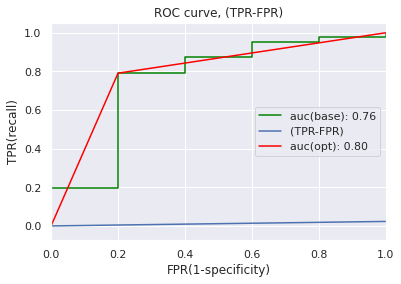

1    101
0     26
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.9047619047619048
validation_sets' accuracy : 0.8901098901098901
validation_sets' f1-score : 0.9404761904761905
 
<<model: svc>> 
               precision    recall  f1-score   support

           0       0.22      0.40      0.29         5
           1       0.96      0.92      0.94        86

    accuracy                           0.89        91
   macro avg       0.59      0.66      0.61        91
weighted avg       0.92      0.89      0.90        91

thresholds optimization
 >> idx: 10, threshold:0.3538974019298031
threshold_opt 
               precision    recall  f1-score   support

           0       0.33      0.40      0.36         5
           1       0.96      0.95      0.96        86

    accuracy                           0.92        91
   macro 

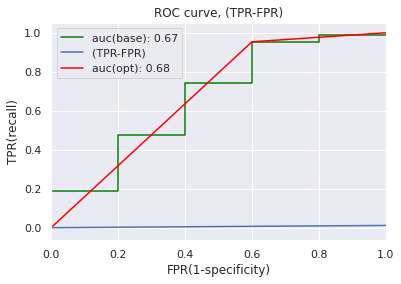

1    104
0     23
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.8791208791208791
validation_sets' f1-score : 0.935672514619883
 
<<model: decisiontreeclassifier>> 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.94      0.93      0.94        86

    accuracy                           0.88        91
   macro avg       0.47      0.47      0.47        91
weighted avg       0.89      0.88      0.88        91

thresholds optimization
 >> idx: 0, threshold:2.0
threshold_opt 
               precision    recall  f1-score   support

           0       0.05      1.00      0.10         5
           1       0.00      0.00      0.00        86

    accuracy                           0.05        91
   macr

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


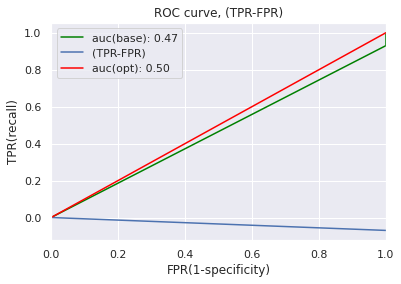

1    112
0     15
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.9340659340659341
validation_sets' f1-score : 0.9659090909090908
 
<<model: randomforestclassifier>> 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.94      0.99      0.97        86

    accuracy                           0.93        91
   macro avg       0.47      0.49      0.48        91
weighted avg       0.89      0.93      0.91        91

thresholds optimization
 >> idx: 15, threshold:0.89
threshold_opt 
               precision    recall  f1-score   support

           0       0.17      1.00      0.29         5
           1       1.00      0.72      0.84        86

    accuracy                           0.74        91
   m

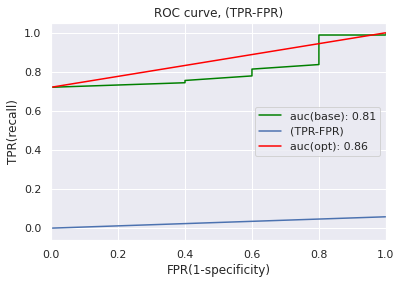

1    123
0      4
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.8666666666666667
validation_sets' accuracy : 0.8351648351648352
validation_sets' f1-score : 0.9079754601226995
 
<<model: kneighborsclassifier>> 
               precision    recall  f1-score   support

           0       0.14      0.40      0.21         5
           1       0.96      0.86      0.91        86

    accuracy                           0.84        91
   macro avg       0.55      0.63      0.56        91
weighted avg       0.92      0.84      0.87        91

thresholds optimization
 >> idx: 2, threshold:0.8
threshold_opt 
               precision    recall  f1-score   support

           0       0.12      0.60      0.21         5
           1       0.97      0.76      0.85        86

    accuracy                           0.75        91
   macro

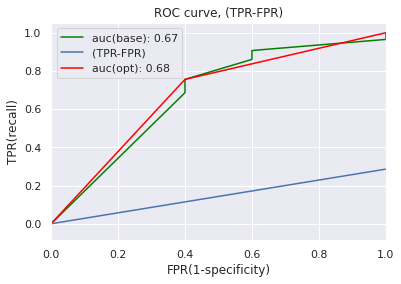

1    100
0     27
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.9340659340659341
validation_sets' f1-score : 0.9655172413793104
 
<<model: gradientboostingclassifier>> 
               precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.95      0.98      0.97        86

    accuracy                           0.93        91
   macro avg       0.64      0.59      0.61        91
weighted avg       0.92      0.93      0.93        91

thresholds optimization
 >> idx: 4, threshold:0.9992671215546285
threshold_opt 
               precision    recall  f1-score   support

           0       0.08      1.00      0.15         5
           1       1.00      0.33      0.49        86

    accuracy                           0.

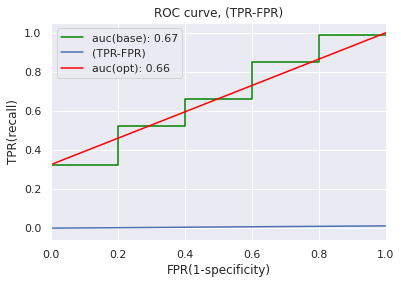

1    117
0     10
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.945054945054945
validation_sets' f1-score : 0.9714285714285714
 
<<model: lgbmclassifier>> 
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.96      0.99      0.97        86

    accuracy                           0.95        91
   macro avg       0.73      0.59      0.63        91
weighted avg       0.93      0.95      0.93        91

thresholds optimization
 >> idx: 6, threshold:0.9998821249998887
threshold_opt 
               precision    recall  f1-score   support

           0       0.09      1.00      0.17         5
           1       1.00      0.42      0.59        86

    accuracy                           0.45        91


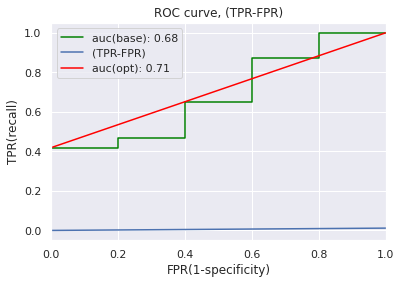

1    121
0      6
dtype: int64
**************************************** end!! ****************************************
**************************************** start!! ****************************************
train_sets' accuracy : 0.9952380952380953
validation_sets' accuracy : 0.945054945054945
validation_sets' f1-score : 0.9714285714285714
 
<<model: xgbclassifier>> 
               precision    recall  f1-score   support

           0       0.50      0.20      0.29         5
           1       0.96      0.99      0.97        86

    accuracy                           0.95        91
   macro avg       0.73      0.59      0.63        91
weighted avg       0.93      0.95      0.93        91

thresholds optimization
 >> idx: 8, threshold:0.9899618625640869
threshold_opt 
               precision    recall  f1-score   support

           0       0.14      0.80      0.24         5
           1       0.98      0.71      0.82        86

    accuracy                           0.71        91
 

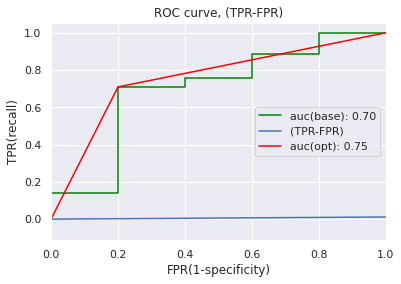

1    122
0      5
dtype: int64
**************************************** end!! ****************************************


In [63]:
## 모델 파이프라인(+SMOTE -class_weight = 'balanced')
logit_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), LogisticRegression(n_jobs = -1,  random_state = 42))
svc_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), SVC(random_state=42 , probability = True))
dt_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), DecisionTreeClassifier(random_state=42))
rf_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), RandomForestClassifier(random_state=42))
knn_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), KNeighborsClassifier())
gbm_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), GradientBoostingClassifier(random_state = 42))
lgbm_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), LGBMClassifier(random_state=42))
xgb_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), XGBClassifier(random_state = 42))

## pipe
pipe = [logit_pipe, svc_pipe, dt_pipe, rf_pipe, knn_pipe, gbm_pipe, lgbm_pipe, xgb_pipe]

## 모델링 함수
def modeling(pipe, X_train, y_train, X_val, y_val, X_test):

    #train/val : accuracy
    pipe.fit(X_train, y_train)
    print("****"*10+" start!! "+ "****"*10)
    print(f"train_sets' accuracy : {pipe.score(X_train, y_train)}")
    print(f"validation_sets' accuracy : {pipe.score(X_val, y_val)}")

    # classification report
    y_val_pred = pipe.predict(X_val)
    print(f"validation_sets' f1-score : {f1_score(y_val, y_val_pred)}")
    print(" ")
    print(f"<<model: {pipe.steps[2][0]}>> \n {classification_report(y_val, y_val_pred)}")
    
    # ROC-curve
    y_val_pred_proba = pipe.predict_proba(X_val)[:,1] # target : class = 1 인 경우
    fpr, tpr, threshold = roc_curve(y_val, y_val_pred_proba)  

    # fpr: 위양성률(실제 neg 중 FP), specificity: 실제 neg 중 TN), tpr: 재현율(실제 pos 중 TP)
    plt.plot(fpr, tpr, color = 'green', label = f'auc(base): {roc_auc_score(y_val, y_val_pred_proba):.2f}')
    plt.xlim(0,1)
    plt.title("ROC curve, (TPR-FPR)")
    plt.xlabel("FPR(1-specificity)")
    plt.legend()
    plt.ylabel("TPR(recall)")

    # threshold optimize!
    optimal_idx = np.argmax(tpr-fpr)
    optimal_threshold = threshold[optimal_idx]
    print("thresholds optimization")
    print(f" >> idx: {optimal_idx}, threshold:{optimal_threshold}")
    sens , spec = tpr[optimal_idx], 1-fpr[optimal_idx]
    plt.plot(tpr-fpr, label = '(TPR-FPR)')
    plt.legend()

    y_pred_opt = (y_val_pred_proba >= optimal_threshold).astype(bool)
    print(f"threshold_opt \n {classification_report(y_val, y_pred_opt)}")

    # auc score 비교
    auc_score_1 = roc_auc_score(y_val, y_val_pred_proba)
    auc_score_2 = roc_auc_score(y_val, y_pred_opt)
    print(f"auc score 비교: original_auc - {auc_score_1}, threshold_opt: {auc_score_2}")
    print(" ")

    ## threshold 적용 후 ROC-curve
    fpr, tpr, threshold = roc_curve(y_val, y_pred_opt)  
    plt.plot(fpr, tpr, color = 'red', label = f'auc(opt): {roc_auc_score(y_val, y_pred_opt):.2f}')
    plt.legend()
    plt.show()

    #test
    y_test_pred = pipe.predict(X_test)
    y_pred = pd.DataFrame(y_test_pred)
    print(y_pred.value_counts())
    print("****"*10+" end!! "+ "****"*10)

for pi in pipe:
    modeling(pi, X_train, y_train, X_val, y_val, X_test)

### 최종 모델 선정
 * SVM, RandomForest, XGBoost, LGBM, Gradientboosting

In [64]:
## base: 모든 값을 최빈값(mode) == 1로 한 경우 
freq = y_train.mode()[0]
y_base = [freq] * len(y_train)

from sklearn.metrics import f1_score, accuracy_score
print(f"train >> f1:{f1_score(y_train, y_base)}, accuracy: {accuracy_score(y_train, y_base)}")


freq = y_val.mode()[0]
y_base2 = [freq] * len(y_val)
print(f"validation >> f1:{f1_score(y_val, y_base2)}, accuracy: {accuracy_score(y_val, y_base2)}, auc score: {roc_auc_score(y_val, y_base2)}")

train >> f1:0.975609756097561, accuracy: 0.9523809523809523
validation >> f1:0.9717514124293786, accuracy: 0.945054945054945, auc score: 0.5


#### (참고) Logisticregression CV

In [65]:
### 하이퍼파라미터 튜닝 for 3 CV
## SVC

np.random.seed(42)
C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
penalty = ['l1','l2']
class_weight = ['balanced', None]

logit_grid = {'logisticregression__C': C, 'logisticregression__penalty' : penalty, 'logisticregression__class_weight' : class_weight}

logit_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), LogisticRegression(solver = 'liblinear',random_state=42))

logit_random = GridSearchCV(estimator = logit_pipe, param_grid = logit_grid, scoring = 'f1', cv = 5, verbose=0)
print(logit_random.get_params().keys())

logit_random.fit(X, y)
## best_parameters
print(logit_random.best_params_)

# best_parameters 추출
b_C  = logit_random.best_params_['logisticregression__C']
b_penalty = logit_random.best_params_['logisticregression__penalty'] 
b_class_weight = logit_random.best_params_['logisticregression__class_weight'] 

## best parameter 적용하여 fit - predict
logit_tune_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), LogisticRegression(solver = 'liblinear',
                                                                                           C = b_C, penalty = b_penalty,
                                                                            class_weight =b_class_weight, random_state=42))

logit_tune_pipe.fit(X, y)
scores = cross_validate(logit_tune_pipe, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)

# x_test predict
logit_pred = logit_tune_pipe.predict(X_test)
logit_pred_proba = logit_tune_pipe.predict_proba(X_test)

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__columntransformer', 'estimator__smote', 'estimator__logisticregression', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__verbose', 'estimator__columntransformer__verbose_feature_names_out', 'estimator__columntransformer__ordinalencoder', 'estimator__columntransformer__onehotencoder', 'estimator__columntransformer__standardscaler', 'estimator__columntransformer__ordinalencoder__cols', 'estimator__columntransformer__ordinalencoder__drop_invariant', 'estimator__columntransformer__ordinalencoder__handle_missing', 'estimator__columntransformer__ordinalencoder__handle_unknown', 'estimator__columntransformer__ordinalencoder__mapping', 'estimator__columntransformer__ordinalenco

In [66]:
submission.OC = logit_pred
submission.to_csv('n_logit.csv',index = False)   # 제출결과: 0.7142857143/0.671875
submission.OC.value_counts() 

1    100
0     27
Name: OC, dtype: int64

#### SVM(Support Vector Macnine) CV

In [67]:
### 하이퍼파라미터 튜닝 for 3 CV
## SVC

np.random.seed(42)
C = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]
kernel = ['linear','rbf', 'sigmoid']
gamma = ['scale', 'auto']
class_weight = ['balanced', None]

svc_grid = {'svc__C': C, 'svc__kernel' : kernel, 
           'svc__gamma': gamma, 'svc__class_weight' : class_weight}

svc_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), SVC(random_state=42 , probability = True))

svc_random = GridSearchCV(estimator = svc_pipe, param_grid = svc_grid, scoring = 'f1', cv = 5, verbose=2, n_jobs = -1)
print(svc_random.get_params().keys())

svc_random.fit(X, y)
## best_parameters
print(svc_random.best_params_)

# best_parameters 추출
b_C  = svc_random.best_params_['svc__C']
b_kernel = svc_random.best_params_['svc__kernel'] 
b_gamma = svc_random.best_params_['svc__gamma'] 
b_class_weight = svc_random.best_params_['svc__class_weight'] 

## best parameter 적용하여 fit - predict
svc_tune_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), SVC(C = b_C,
                                                                            kernel = b_kernel,
                                                                            gamma = b_gamma,
                                                                            class_weight =b_class_weight, 
                                                                            probability = True, random_state=42))

svc_tune_pipe.fit(X, y)

scores = cross_validate(svc_tune_pipe, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)

# x_test predict
svc_pred = svc_tune_pipe.predict(X_test)
svc_pred_proba = svc_tune_pipe.predict_proba(X_test)

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__columntransformer', 'estimator__smote', 'estimator__svc', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__verbose', 'estimator__columntransformer__verbose_feature_names_out', 'estimator__columntransformer__ordinalencoder', 'estimator__columntransformer__onehotencoder', 'estimator__columntransformer__standardscaler', 'estimator__columntransformer__ordinalencoder__cols', 'estimator__columntransformer__ordinalencoder__drop_invariant', 'estimator__columntransformer__ordinalencoder__handle_missing', 'estimator__columntransformer__ordinalencoder__handle_unknown', 'estimator__columntransformer__ordinalencoder__mapping', 'estimator__columntransformer__ordinalencoder__return_df'

In [68]:
#svc_tune_pipe.named_steps['svc'].support_vectors_

In [69]:
submission.OC = svc_pred
submission.to_csv('n_svc.csv',index = False)   # 제출결과: 0.84127/0.78125
submission.OC.value_counts() 

1    123
0      4
Name: OC, dtype: int64

#### randomforest classifier CV 

In [70]:
### 하이퍼파라미터 튜닝 for CV
## random forest
np.random.seed(42)
n_estimators = [n for n in np.arange(10,70,10)]
max_depth = [n for n in np.arange(5,20,5)]
max_features = ['auto', 'sqrt', 'log2']
class_weight = ['balanced', 'balanced_subsample', None]
criterion = ['gini', 'entropy']

rf_grid = {'randomforestclassifier__n_estimators': n_estimators, 'randomforestclassifier__max_depth' : max_depth, 
           'randomforestclassifier__max_features': max_features, 'randomforestclassifier__class_weight' : class_weight,
           'randomforestclassifier__criterion': criterion}

rf_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), RandomForestClassifier(random_state=42))

rf_random = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, scoring = 'f1', cv = 5, verbose=2, n_jobs = -1)
print(rf_random.get_params().keys())

rf_random.fit(X, y)

## best_parameters
print(rf_random.best_params_)

# best_parameters 추출
b_estimators  = rf_random.best_params_['randomforestclassifier__n_estimators']
b_max_depth = rf_random.best_params_['randomforestclassifier__max_depth'] 
b_max_features = rf_random.best_params_['randomforestclassifier__max_features'] 
b_class_weight = rf_random.best_params_['randomforestclassifier__class_weight'] 
b_criterion = rf_random.best_params_['randomforestclassifier__criterion']

## best parameter 적용하여 fit - predict
rf_tune_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), 
                             RandomForestClassifier(n_estimators = b_estimators,
                                                    max_depth = b_max_depth,
                                                    max_features = b_max_features,
                                                    class_weight =b_class_weight,
                                                    criterion = b_criterion, random_state=42))

rf_tune_pipe.fit(X, y)
scores = cross_validate(rf_tune_pipe, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)

# x_test predict
rf_pred = rf_tune_pipe.predict(X_test)
rf_pred_proba = rf_tune_pipe.predict_proba(X_test)

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__columntransformer', 'estimator__smote', 'estimator__randomforestclassifier', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__verbose', 'estimator__columntransformer__verbose_feature_names_out', 'estimator__columntransformer__ordinalencoder', 'estimator__columntransformer__onehotencoder', 'estimator__columntransformer__standardscaler', 'estimator__columntransformer__ordinalencoder__cols', 'estimator__columntransformer__ordinalencoder__drop_invariant', 'estimator__columntransformer__ordinalencoder__handle_missing', 'estimator__columntransformer__ordinalencoder__handle_unknown', 'estimator__columntransformer__ordinalencoder__mapping', 'estimator__columntransformer__ordinal

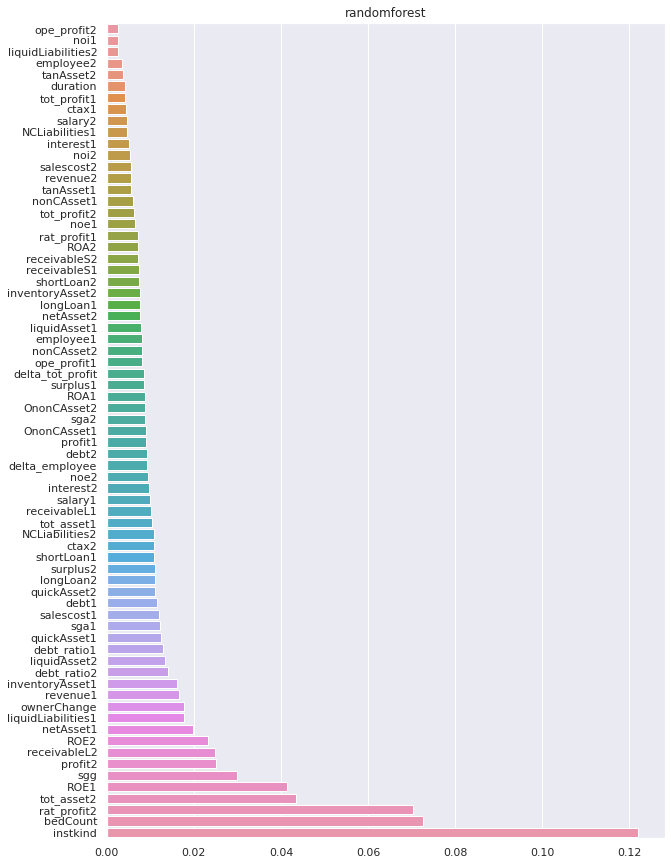

In [71]:
## 중요 feature 확인
imp = rf_tune_pipe.named_steps['randomforestclassifier'].feature_importances_
cols = rf_tune_pipe.feature_names_in_

# sort indexes
sorted_indx = np.argsort(imp)
sorted_imp = imp[sorted_indx]
sorted_cols = cols[sorted_indx]

# plot
plt.figure(figsize=(10,15))
sns.barplot(y = sorted_cols, x = sorted_imp)
plt.title("randomforest")
plt.show();

In [72]:
submission.OC = rf_pred
submission.to_csv('n_rf.csv',index = False)   # 제출결과: 0.8412698/0.8125
submission.OC.value_counts() 

1    124
0      3
Name: OC, dtype: int64

#### xgboost CV

In [73]:
### 하이퍼파라미터 튜닝 for 3 CV
## xgboost
np.random.seed(42)

learning_rate = [n for n in np.arange(0.05,0.2,0.05)]
n_estimators =  [n for n in np.arange(10,70,10)]
max_depth = [n for n in np.arange(3,10,1)]
min_child_weight = [n for n in np.arange(0,10,0.5)]
scale_pos_weight = [n for n in np.arange(0,1,0.5)]


xgb_grid = {'xgbclassifier__n_estimators': n_estimators, 'xgbclassifier__learning_rate' :learning_rate, 
           'xgbclassifier__max_depth': max_depth, 'xgbclassifier__min_child_weight' : min_child_weight,
           'xgbclassifier__scale_pos_weight': scale_pos_weight }

xgb_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), XGBClassifier(objective = 'binary:logistic',random_state = 42))

xgb_random = GridSearchCV(estimator = xgb_pipe, param_grid = xgb_grid, scoring = 'f1', cv = 5, verbose=2, n_jobs = -1)
print(xgb_random.get_params().keys())

xgb_random.fit(X, y)

## best_parameters
print(xgb_random.best_params_)

# best_parameters 추출
b_estimators  = xgb_random.best_params_['xgbclassifier__n_estimators']
b_learning_rate = xgb_random.best_params_['xgbclassifier__learning_rate'] 
b_max_depth = xgb_random.best_params_['xgbclassifier__max_depth'] 
b_min_child_weight = xgb_random.best_params_['xgbclassifier__min_child_weight'] 
b_scale_pos_weight = xgb_random.best_params_['xgbclassifier__scale_pos_weight']

## best parameter 적용하여 fit - predict
xgb_tune_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), 
                             XGBClassifier(objective = 'binary:logistic',
                                           n_estimators = b_estimators,
                                           learning_rate = b_learning_rate,
                                            max_depth = b_max_depth,
                                            min_child_weight = b_min_child_weight,
                                            scale_pos_weight = b_scale_pos_weight, random_state=42))

xgb_tune_pipe.fit(X, y)
scores = cross_validate(xgb_tune_pipe, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)

# x_test predict
xgb_pred = xgb_tune_pipe.predict(X_test)
xgb_pred_proba = xgb_tune_pipe.predict_proba(X_test)

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__columntransformer', 'estimator__smote', 'estimator__xgbclassifier', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__verbose', 'estimator__columntransformer__verbose_feature_names_out', 'estimator__columntransformer__ordinalencoder', 'estimator__columntransformer__onehotencoder', 'estimator__columntransformer__standardscaler', 'estimator__columntransformer__ordinalencoder__cols', 'estimator__columntransformer__ordinalencoder__drop_invariant', 'estimator__columntransformer__ordinalencoder__handle_missing', 'estimator__columntransformer__ordinalencoder__handle_unknown', 'estimator__columntransformer__ordinalencoder__mapping', 'estimator__columntransformer__ordinalencoder__

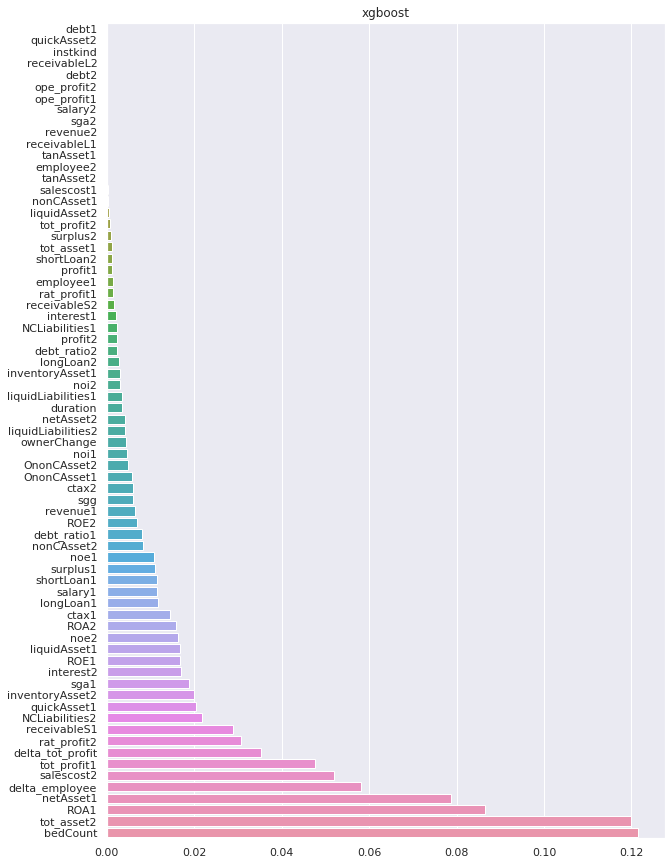

In [74]:
## 중요 feature 확인
imp = xgb_tune_pipe.named_steps['xgbclassifier'].feature_importances_
cols = xgb_tune_pipe.feature_names_in_

# sort indexes
sorted_indx = np.argsort(imp)
sorted_imp = imp[sorted_indx]
sorted_cols = cols[sorted_indx]

# plot
plt.figure(figsize=(10,15))
sns.barplot(y = sorted_cols, x = sorted_imp)
plt.title("xgboost")
plt.show();

In [75]:
submission.OC = rf_pred
submission.to_csv('n_xgb.csv',index = False)   # 제출결과: 0.84126984/0.8125
submission.OC.value_counts() 

1    124
0      3
Name: OC, dtype: int64

In [76]:
imp = xgb_tune_pipe.named_steps['xgbclassifier'].feature_importances_
cols = xgb_tune_pipe.feature_names_in_

# sort indexes
sorted_indx = np.argsort(imp)
sorted_imp = imp[sorted_indx]
sorted_cols = cols[sorted_indx]



#### LGBM CV

In [77]:
### 하이퍼파라미터 튜닝 for 3 CV
## LGBM
np.random.seed(42)

learning_rate = [n for n in np.arange(0.05,0.2,0.05)]
n_estimators =  [n for n in np.arange(10,70,10)]
max_depth = [n for n in np.arange(3,10,1)]

lgbm_grid = {'lgbmclassifier__n_estimators': n_estimators, 'lgbmclassifier__learning_rate' :learning_rate, 
           'lgbmclassifier__max_depth': max_depth}

lgbm_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), LGBMClassifier(random_state=42))

lgbm_random = GridSearchCV(estimator = lgbm_pipe, param_grid = lgbm_grid, scoring = 'f1', cv = 5, verbose=2, n_jobs = -1)
print(lgbm_random.get_params().keys())

lgbm_random.fit(X, y)

## best_parameters
print(lgbm_random.best_params_)

# best_parameters 추출
b_estimators  = lgbm_random.best_params_['lgbmclassifier__n_estimators']
b_learning_rate = lgbm_random.best_params_['lgbmclassifier__learning_rate'] 
b_max_depth = lgbm_random.best_params_['lgbmclassifier__max_depth'] 
np.random.seed(42)


## best parameter 적용하여 fit - predict
lgbm_tune_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), 
                             LGBMClassifier(n_estimators = b_estimators,
                                           learning_rate = b_learning_rate,
                                            max_depth = b_max_depth, random_state=42))

lgbm_tune_pipe.fit(X, y)
scores = cross_validate(lgbm_tune_pipe, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)

# x_test predict
lgbm_pred = lgbm_tune_pipe.predict(X_test)
lgbm_pred_proba = lgbm_tune_pipe.predict_proba(X_test)

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__columntransformer', 'estimator__smote', 'estimator__lgbmclassifier', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__verbose', 'estimator__columntransformer__verbose_feature_names_out', 'estimator__columntransformer__ordinalencoder', 'estimator__columntransformer__onehotencoder', 'estimator__columntransformer__standardscaler', 'estimator__columntransformer__ordinalencoder__cols', 'estimator__columntransformer__ordinalencoder__drop_invariant', 'estimator__columntransformer__ordinalencoder__handle_missing', 'estimator__columntransformer__ordinalencoder__handle_unknown', 'estimator__columntransformer__ordinalencoder__mapping', 'estimator__columntransformer__ordinalencoder_

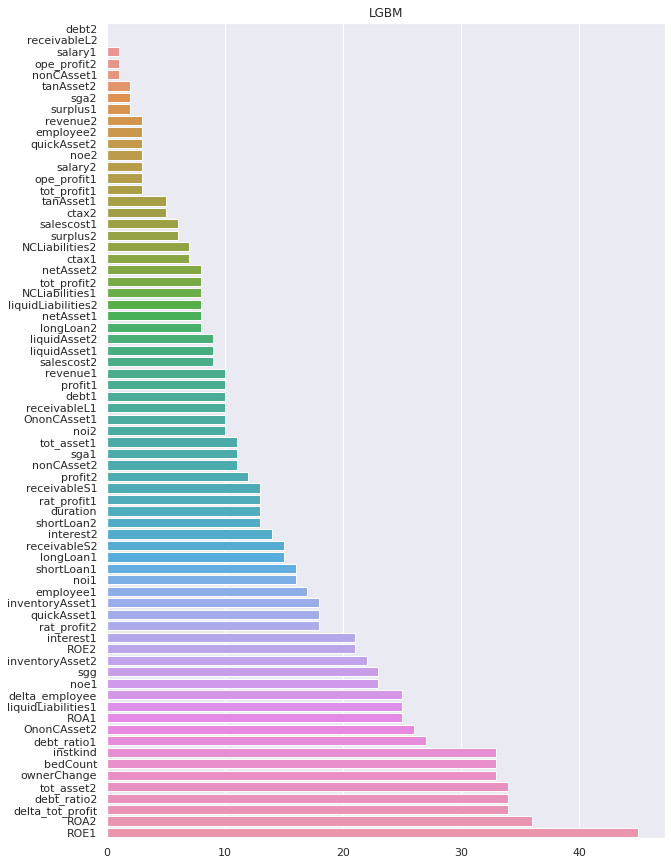

In [78]:
## 중요 feature 확인
imp = lgbm_tune_pipe.named_steps['lgbmclassifier'].feature_importances_
cols = lgbm_tune_pipe.feature_names_in_

# sort indexes
sorted_indx = np.argsort(imp)
sorted_imp = imp[sorted_indx]
sorted_cols = cols[sorted_indx]

# plot
plt.figure(figsize=(10,15))
sns.barplot(y = sorted_cols, x = sorted_imp)
plt.title("LGBM")
plt.show();

In [79]:
submission.OC = lgbm_pred
submission.to_csv('n_lgbm.csv',index = False)   # 제출결과: 0.857142/0.828125
submission.OC.value_counts() 

1    119
0      8
Name: OC, dtype: int64

#### GradientBoosting CV

In [80]:
### 하이퍼파라미터 튜닝 for 3 CV
## gredientboosting classifier
np.random.seed(42)

n_estimators = [n for n in np.arange(10,70,10)]
max_depth = [n for n in np.arange(5,20,5)]
learning_rate = [n for n in np.arange(0.05,0.2,0.05)]

gbm_grid = {'gradientboostingclassifier__n_estimators': n_estimators, 'gradientboostingclassifier__max_depth' : max_depth, 
           'gradientboostingclassifier__learning_rate':learning_rate }

gbm_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), GradientBoostingClassifier(random_state = 42))

gbm_random = GridSearchCV(estimator = gbm_pipe, param_grid = gbm_grid, scoring = 'f1', 
                         cv = 5, verbose=2, n_jobs = -1)

print(gbm_random.get_params().keys())
gbm_random.fit(X, y)

## best_parameters
print(gbm_random.best_params_)

# best_parameters 추출
b_estimators  = gbm_random.best_params_['gradientboostingclassifier__n_estimators']
b_learning_rate = gbm_random.best_params_['gradientboostingclassifier__learning_rate'] 
b_max_depth = gbm_random.best_params_['gradientboostingclassifier__max_depth'] 

## best parameter 적용하여 fit - predict
gbm_tune_pipe = make_pipeline(preprocessor, SMOTE(random_state = 42), GradientBoostingClassifier(n_estimators = b_estimators,
                                                                                            learning_rate = b_learning_rate,
                                                                                            max_depth = b_max_depth, random_state=42))

gbm_tune_pipe.fit(X, y)
scores = cross_validate(gbm_tune_pipe, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)

# x_test predict
gbm_pred = gbm_tune_pipe.predict(X_test)
gbm_pred_proba = gbm_tune_pipe.predict_proba(X_test)


dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__columntransformer', 'estimator__smote', 'estimator__gradientboostingclassifier', 'estimator__columntransformer__n_jobs', 'estimator__columntransformer__remainder', 'estimator__columntransformer__sparse_threshold', 'estimator__columntransformer__transformer_weights', 'estimator__columntransformer__transformers', 'estimator__columntransformer__verbose', 'estimator__columntransformer__verbose_feature_names_out', 'estimator__columntransformer__ordinalencoder', 'estimator__columntransformer__onehotencoder', 'estimator__columntransformer__standardscaler', 'estimator__columntransformer__ordinalencoder__cols', 'estimator__columntransformer__ordinalencoder__drop_invariant', 'estimator__columntransformer__ordinalencoder__handle_missing', 'estimator__columntransformer__ordinalencoder__handle_unknown', 'estimator__columntransformer__ordinalencoder__mapping', 'estimator__columntransformer__ord

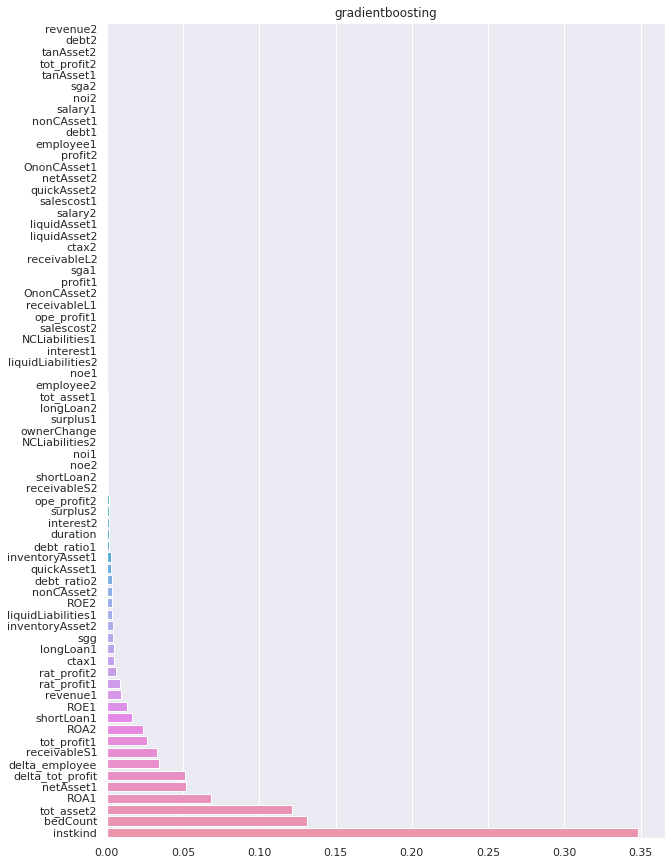

In [81]:
## 중요 feature 확인
imp = gbm_tune_pipe.named_steps['gradientboostingclassifier'].feature_importances_
cols = gbm_tune_pipe.feature_names_in_

# sort indexes
sorted_indx = np.argsort(imp)
sorted_imp = imp[sorted_indx]
sorted_cols = cols[sorted_indx]

# plot
plt.figure(figsize=(10,15))
sns.barplot(y = sorted_cols, x = sorted_imp)
plt.title("gradientboosting")
plt.show();

In [82]:
submission.OC = rf_pred
submission.to_csv('n_gbm.csv',index = False)   # 제출결과: 0.873016/0.84375
submission.OC.value_counts() 

1    124
0      3
Name: OC, dtype: int64

### voting classifier 

In [100]:
vot_clf = VotingClassifier(estimators = [ ('gbm', gbm_tune_pipe), ('xgb', xgb_tune_pipe), ('lgbm', lgbm_tune_pipe)], voting = 'soft')
#scores = cross_val_score(vot_clf, X, y, cv=5) 
scores = cross_validate(vot_clf, X, y, cv = 5, scoring=('accuracy', 'f1'), error_score='raise', return_train_score=True)
print(scores)
vot_clf.fit(X, y)
vot_y = vot_clf.predict(X_test)

{'fit_time': array([1.76651525, 1.66970396, 1.98521399, 1.14966464, 1.10310745]), 'score_time': array([0.04983306, 0.04879069, 0.18402553, 0.02996778, 0.02877617]), 'test_accuracy': array([0.93442623, 0.9       , 0.93333333, 0.95      , 0.88333333]), 'train_accuracy': array([0.99166667, 0.99170124, 0.99585062, 0.99585062, 0.99170124]), 'test_f1': array([0.96610169, 0.94736842, 0.96551724, 0.97435897, 0.9380531 ]), 'train_f1': array([0.99559471, 0.99561404, 0.99781182, 0.99781182, 0.99561404])}


In [101]:
submission.OC = vot_y
submission.to_csv('n_vt.csv',index = False) 
submission.OC.value_counts() 

1    121
0      6
Name: OC, dtype: int64